# Dependancies

In [76]:
import gpxpy
import gpxpy.gpx

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from geopy.distance import distance
from geopy.distance import geodesic
from geopy import distance
import math

import haversine as hs
import numpy as np

import datetime
from time import strftime
from time import gmtime

import folium

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
from IPython.display import display

# Enter route

In [97]:
name = 'vhtrc-mmt-training-two-2021'

with open('Routes/'+name+'.gpx', 'r') as gpx_file:
    route = gpxpy.parse(gpx_file)

In [98]:
## load all the files in a folder
# import pandas as pd
# import glob
# files = glob.glob("path/*.csv")
# df = []
# for f in files:
#     csv = pd.read_csv(f)
#     df.append(csv)
# df = pd.concat(df)

In [99]:
# making a dictionary that can be converted to Pandas Dataframe
route_info=[]

for track in route.tracks:
    for segment in track.segments:
        for point in segment.points:
            route_info.append({
                'time': point.time,
                'latitude': point.latitude,
                'longitude':point.longitude,
                'elevation': point.elevation
            })

df = pd.DataFrame(route_info)

df.to_csv('data/'+name+'.csv', index=False)

In [100]:
pointxyz = []
for i in range(0,len(df)):
    pointxyz.append((df['latitude'][i], df['longitude'][i], df['elevation'][i]))

df['pointxyz']= pd.Series(pointxyz)

def haversine_distance(lat1, lon1, lat2, lon2) -> float:
    distance = hs.haversine(
        point1=(lat1,lon1),
        point2=(lat2,lon2),
        unit=hs.Unit.MILES
    )
    return np.round(distance,8)

distances = [np.nan]
cap_mph = 10
distance_cap = 1/(60/cap_mph*60)

for i in range(len(df)):
    if i == 0:
        continue
    else:
        unit_dist = haversine_distance(
            lat1=df.iloc[i - 1]['latitude'],
            lon1=df.iloc[i - 1]['longitude'],
            lat2=df.iloc[i]['latitude'],
            lon2=df.iloc[i]['longitude']
        )
        # if unit_dist > distance_cap:
        #     distances.append(np.nan)
        # else:
        distances.append(unit_dist)

df['distance'] = distances
df['distance'] = df['distance'].interpolate().fillna(0)

df['elevation_change'] = df['elevation'].diff()
df['cum_elevation'] = df['elevation_change'].cumsum()
df['cum_distance'] = df['distance'].cumsum()
# df = df.fillna(0)

df['step_feet'] = df['distance'] * 5280

df.to_csv('data/'+name+'.csv', index=False)



# Elevation plot

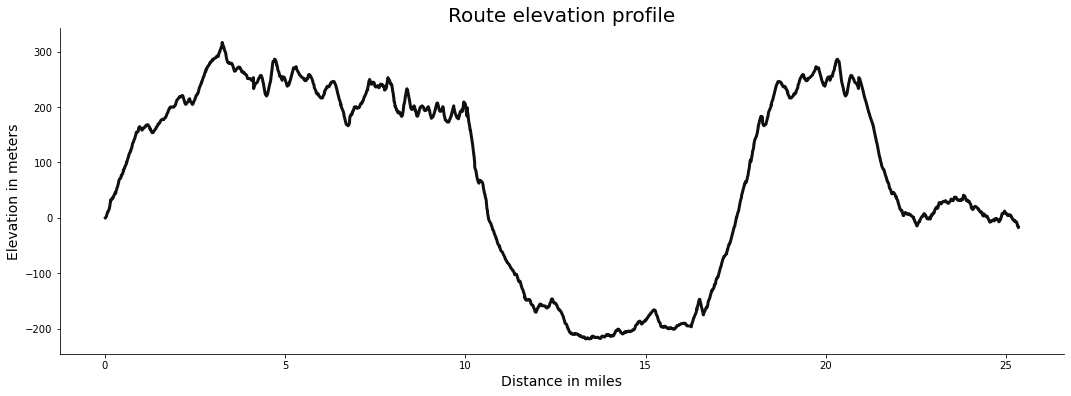

In [101]:
plt.figure(figsize=(18,6))
plt.plot(df['cum_distance'], df['cum_elevation'], color='#101010', lw=3)
plt.title('Route elevation profile', size=20)
plt.xlabel('Distance in miles', size=14)
plt.ylabel('Elevation in meters', size=14);

In [105]:
def find_neighbours(value, df, colname):
    exactmatch = df[df[colname] == value]
    if not exactmatch.empty:
        return exactmatch.index
    else:
        lowerneighbour_ind = df[df[colname] < value][colname].idxmax()
        upperneighbour_ind = df[df[colname] > value][colname].idxmin()
        return [lowerneighbour_ind, upperneighbour_ind] 

def make_mile_segments(row):
    return row['cum_distance']//1 +1
df['mile_num'] = df.apply(make_mile_segments, axis=1)

# find the begining location of each mile
def mile_marker_loc(df):
    mile_markers = []

    for i in range(1,len(df['mile_num'].unique())):
        junder,jover  = find_neighbours(i, df, 'cum_distance')
        mile_markers.append(jover)
    return mile_markers


In [106]:
from folium.features import DivIcon

def number_DivIcon(color,number):
    """ Create a 'numbered' icon
    
    """
    icon = DivIcon(
            icon_size=(150,36),
            icon_anchor=(14,40),
#             html='<div style="font-size: 18pt; align:center, color : black">' + '{:02d}'.format(num+1) + '</div>',
            html="""<span class="fa-stack " style="font-size: 12pt" >>
                    <!-- The icon that will wrap the number -->
                    <span class="fa fa-circle-o fa-stack-2x" style="color : {:s}"></span>
                    <!-- a strong element with the custom content, in this case a number -->
                    <strong class="fa-stack-1x">
                         {:02d}  
                    </strong>
                </span>""".format(color,number)
        )
    return icon
    
col_hex = ['#440154',
 '#481a6c',
 '#472f7d',
 '#414487',
 '#39568c',
 '#31688e',
 '#2a788e',
 '#23888e',
 '#1f988b',
 '#22a884',
 '#35b779',
 '#54c568',
 '#7ad151',
 '#a5db36',
 '#d2e21b'
 ]

# Miler Markers on route

In [107]:
# Graph mile markers on map with mile time on click - folium
lat_map = df['latitude'].mean()
lon_map = df['longitude'].mean()
route_map = folium.Map(
    location=[lat_map, lon_map],
    zoom_start=13,
    tiles='OpenStreetMap',
    width= 1000,
    height=800
)
coordinates = [tuple(x) for x in df[['latitude','longitude']].to_numpy()]
folium.PolyLine(coordinates, weight=6).add_to(route_map)

# find mile markers
locations_to_chart = mile_marker_loc(df)
# find mile times
# mile_times = run_miles(df)
num =0
mile=1

for i in locations_to_chart:
    mile_hex = mile//15+1
    loc = [df['latitude'][i], df['longitude'][i]]
    folium.Marker(
        location=loc,
        popup="Mile " + '{:02d}'.format(mile),
        icon=folium.Icon(color='white',icon_color='white'),
        markerColor=col_hex[mile_hex]
    ).add_to(route_map)

    # folium.Marker(
    #     location=loc,
    #     popup="Mile " + '{:02d}'.format(mile)+ " "+ mile_times[mile-1],
    #     icon= number_DivIcon(col_hex[mile_hex],mile)
    # ).add_to(route_map)
    # mile+=1

    folium.Marker(
        location=loc,
        popup="Mile " + '{:02d}'.format(mile),
        icon= number_DivIcon(col_hex[mile_hex],mile)
    ).add_to(route_map)
    mile+=1



display(route_map)

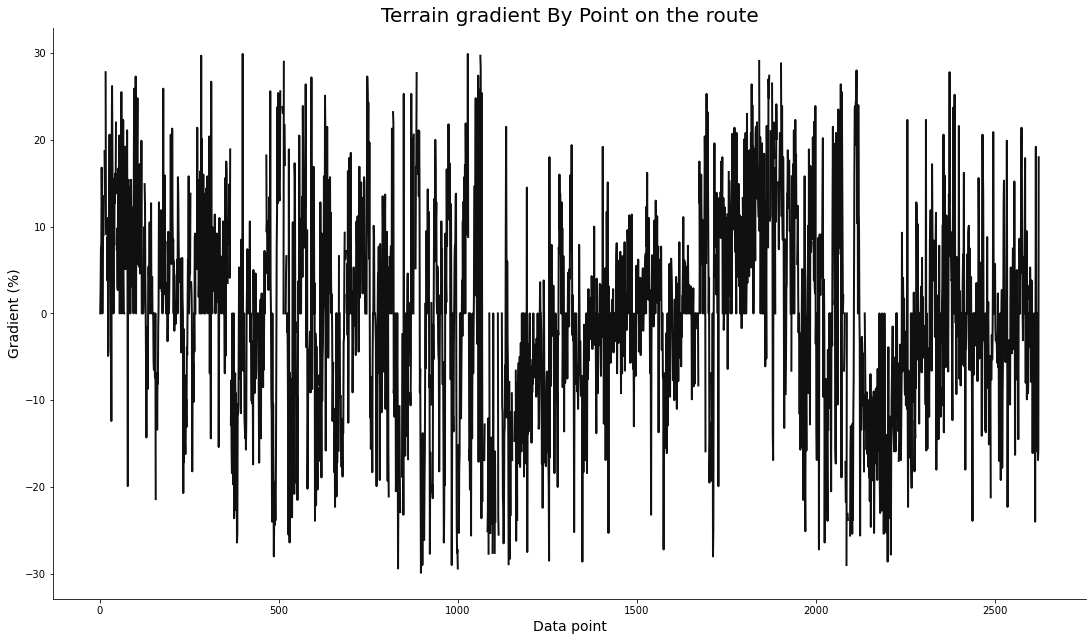

In [108]:
# gradient just from each step
grade_cap_high = 30
conversion_factor = 0.62137119
gradient_each_point =[np.nan]
for ind, row in df.iterrows():
    if ind == 0:
        continue
    grade = (row['elevation_change'] / ((row['distance']/conversion_factor*1000)+1))*100
    if abs(grade) > grade_cap_high :
        gradient_each_point.append(np.nan)
    else:
        gradient_each_point.append(np.round(grade,1))
    
# plt.figure(figsize=(18.5, 10.5))
# plt.title('Terrain gradient By Point on the route', size=20)
# plt.xlabel('Data point', size=14)
# plt.ylabel('Gradient (%)', size=14)
# plt.plot(np.arange(len(gradient_each_point)), gradient_each_point, lw=2, color='#101010');

In [109]:
# add to the dataframe
len(gradient_each_point)
df['gradient_each_point'] = gradient_each_point
df['gradient_each_point'] = df['gradient_each_point'].interpolate().fillna(0)

bin_labels_cut = ['bigDown', 'down', 'flat', 'up', 'bigUp']
bin_cuts=[-30, -15, -5, 5, 15, 30]
df['gradient_rating'] = pd.cut(df['gradient_each_point'],
                            bins=bin_cuts,
                            labels=bin_labels_cut)


In [127]:
how_run_grade =[]
diff_grades = df['gradient_rating'].unique()
for i in diff_grades:
    # dict_time_gradient = {}
    how_run_grade.append({
        i+' distance':np.round(df[df['gradient_rating'] == i]['distance'].sum(),2)
    })

    # dict_time_gradient['time'] = int(df[df['gradient_rating'] == i]['distance'].count())
    # dict_time_gradient['speed'] = dict_time_gradient['distance']/(dict_time_gradient['time']/60/60)
    # dict_time_gradient['pace'] = str(datetime.timedelta(seconds=60/dict_time_gradient['speed']*60))

    # how_run_grade[i] = dict_time_gradient

dict_list ={}
for i in how_run_grade:
    dict_list[name] = how_run_grade
# how_run_grade
dict_list


{'vhtrc-mmt-training-two-2021': [{'flat distance': 9.94},
  {'up distance': 5.73},
  {'bigUp distance': 1.89},
  {'down distance': 5.63},
  {'bigDown distance': 2.16}]}

In [151]:
grade_labels = []
for i in range(len(how_run_grade)):
    grade_labels.append(list(how_run_grade[i].keys())[0])

test_df = pd.DataFrame.from_dict(dict_list,orient ='index',columns=grade_labels)
test_df

,flat distance,up distance,bigUp distance,down distance,bigDown distance
vhtrc-mmt-training-two-2021,{'flat distance': 9.94},{'up distance': 5.73},{'bigUp distance': 1.89},{'down distance': 5.63},{'bigDown distance': 2.16}
